<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer

import re
import string
import requests

import squarify

from collections import Counter

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [4]:
df = pd.read_csv('./data/job_listings.csv')

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [5]:
df.head(3)

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level


In [6]:
def mk_soup(html):
    html = html.lstrip('b"\'').rstrip('"\'')
    
    soup = BeautifulSoup(html, 'html.parser')

    return soup.get_text()

In [7]:
df['soup-ed_up'] = df['description'].apply(mk_soup)
df.head()

,Unnamed: 0,description,title,soup-ed_up
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements:\nConceptual understanding in...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description\n\nAs a Data Scientist 1, you ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations\...


## 2) Use Spacy to tokenize / clean the listings 

In [8]:
nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

In [9]:
def get_lemz(text):

    stopwords = []
    lemmas = []

    doc = nlp(text)

    for token in doc:
        if (token.text.lower() not in stopwords):
            if ((token.is_stop == False) & (token.is_punct == False)) & (token.pos_!= 'PRON'):
                lemmas.append(token.lemma_)

    return lemmas

In [10]:
df['lemz'] = df['soup-ed_up'].apply(get_lemz)

In [11]:
df.head(3)

,Unnamed: 0,description,title,soup-ed_up,lemz
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements:\nConceptual understanding in...,"[job, requirements:\nconceptual, understanding..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description\n\nAs a Data Scientist 1, you ...","[job, description\n\nas, Data, Scientist, 1, h..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[Data, scientist, work, consult, business, res..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [12]:
data = df['soup-ed_up']
vect = CountVectorizer(stop_words='english')
vect.fit(data)
dtm = vect.transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [13]:
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [14]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [15]:
wc = count(df['lemz'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
74,datum,408,2791,1.0,0.021929,0.021929,0.957746
55,work,367,1368,2.0,0.010748,0.032677,0.861502
312,team,358,1176,3.0,0.009240,0.041917,0.840376
71,experience,372,1124,4.0,0.008831,0.050748,0.873239
286,business,315,1101,5.0,0.008650,0.059398,0.739437


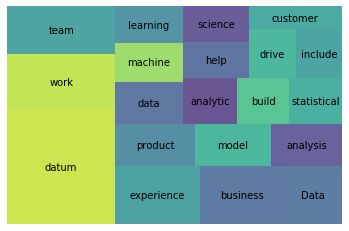

In [16]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [17]:
tfidf = TfidfVectorizer(stop_words='english',
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=get_lemz)

dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,$,"$ 100,000",$ 300,$ 40,+,+ city,+ year,+ years\xe2\x80\x99,.\n\nabout,.\n\nabout role\n\nas,...,you\xe2\x80\x99ll develop,you\xe2\x80\x99ll need\n\nphd,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99re look,you\xe2\x80\x99ve,you\xe2\x80\x99ve work,yrs,|,||
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.026371,0.0,0.028795,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.232986,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.137636,0.0,0.150288,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
dist_mtx = cosine_similarity(dtm)

In [19]:
df2 = pd.DataFrame(dist_mtx)

In [20]:
df2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
0,1.000000,0.045650,0.029604,0.002473,0.019402,0.124377,0.026063,0.031444,0.054430,0.023557,...,0.042647,0.065900,0.034430,0.070152,0.028046,0.026211,0.029225,0.023857,0.052004,0.048411
1,0.045650,1.000000,0.049159,0.027181,0.034114,0.081609,0.084419,0.065881,0.097312,0.076072,...,0.102495,0.132660,0.042016,0.087705,0.089609,0.104154,0.064275,0.066200,0.074958,0.067326
2,0.029604,0.049159,1.000000,0.012400,0.046834,0.059540,0.062980,0.076173,0.077798,0.031076,...,0.038355,0.039272,0.038454,0.091110,0.048833,0.042071,0.035340,0.026159,0.081612,0.054730


In [21]:
df2[15][:5]

0    0.027080
1    0.073150
2    0.041678
3    0.018729
4    0.037550
Name: 15, dtype: float64

In [22]:
df2[df2[15] <1][15].sort_values(ascending=False)[:5]

280    0.185544
397    0.157158
320    0.139111
377    0.139111
363    0.135886
Name: 15, dtype: float64

In [23]:
print(data[15][:300])

The Atlantic is seeking a Data Scientist to help lead research and analysis initiatives and support ongoing delivery of key insights to drive business growth and overall impact. The role will work closely with partners in Consumer Revenue, Advertising, Editorial, and Product to understand performanc


In [24]:
print(data[280][:300])

We are Drybar, a blow dry bar, and we set out to shake up the beauty industry in our own, specialty way. We believe in doing one thing and being the best at it. For us, that\xe2\x80\x99s blowouts. In fact, our tagline says it best: No cuts. No color. Just blowouts. What started with one shop in Bren


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [49]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [52]:
def listing_neighbors(index_num=0):
    
    derp = nn.kneighbors([dtm.loc[index_num]])
    
    derpdf = pd.DataFrame([derp[0][0], derp[1][0]])
    
    return derpdf

In [59]:
listing_neighbors(112)

,0,1,2,3,4
0,0.0,0.0,0.0,1.289293,1.310967
1,112.0,97.0,175.0,301.000000,111.000000


In [86]:
keywords = ['remote location entry level junior position']
key_search = tfidf.transform(keywords)

In [100]:
sample_jobs = nn.kneighbors(key_search.todense())

In [112]:
sample_jobs[1][0]

array([ 23, 123, 256,  69, 402], dtype=int64)

In [115]:
data[256]

'Role Summary:\\nThe CCS Data Scientist is responsible for supporting the CCS digital service operations teams with data analytics that drive improved remote service efficiency and improved customer experience.\\n\\nEssential Responsibilities:\\nIdentify opportunities for rules that drive service efficiencies by performing retrospective analysis of historical machine log data vs service dispatches, apply machine learning techniques to learn what we don\\xe2\\x80\\x99t know and use this to funnel improvements to the rules and remote tools.Continuously look for remote service efficiency opportunities and variable cost productivity from service dispatch data, where necessary lead regional teams and support them to drive process improvements or implement changes that reduce cost and improve customer experience.Produce data visualizations to demonstrate learnings and opportunities that support a wide range of stakeholders.Support pareto of pain analysis and efforts to add automatic root cau

In [118]:
for i in range(1,5):
    listing_index = sample_jobs[1][0][i]
    print(i, '\nArticle index: ', listing_index)
    print(data[listing_index])

1 
Article index:  123
Motiion is a technology and data company for the food industry. We believe in transparency, diversity, merit and fostering a culture of accountability, personal impact and career growth.\n\nAs a member of the first product engineering team at Motiion you have will have a unique opportunity to turning previously scattered and inconsistently structured data into directly actionable food industry insights to reduce waste, increase freshness and much more.\n\nYou have a proven track record of reading data and making solid conclusions. You know both the art and science of analytics - now only do you know how to find answers in the data, you also know which questions should be asked in the first place and what data might could help us further bolster our conclusions. You love engaging with customers, learn about their challenges and then dive into the data to see how to solve them!\n\nWe are building a product engineering team with a breadth of combined experiences so 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 